In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools

from stripROtools import colors



In [2]:
T_off = pd.read_pickle("time_offset.pk")
T_off


,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# UH DLC Micromegas - Quadrant a

In [3]:
Vmesh = [540]

----------- Vmesh =  540 -----------
selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


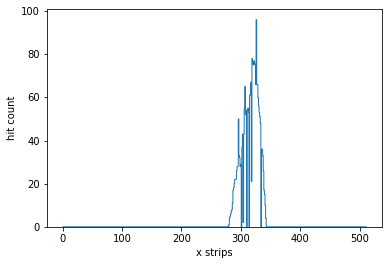

----- Hits on y strips -----


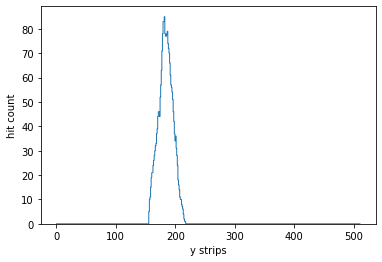

----- Event Time Range-----


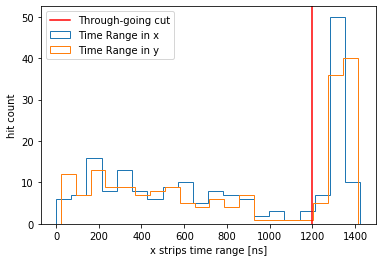

----- ADC distribution-----


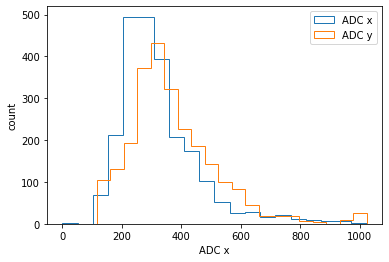

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  31
----- hits in x and y  -----


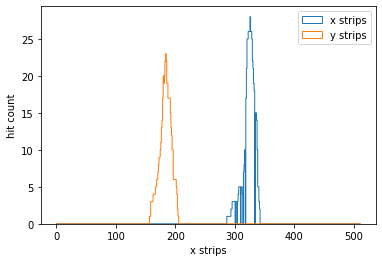

sigma x:  40.301763919986875 +/- 3.5818645267071147
sigma y:  42.21022501506213 +/- 5.203787494442926


/Users/majdghrear/Lab/2DstripRO/stripROtools.py:654: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


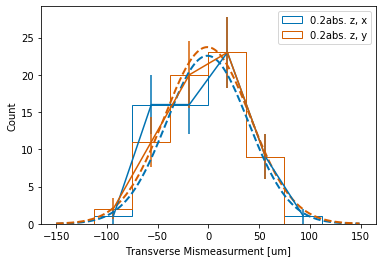

sigma x:  36.93959986075189 +/- 3.9328771118789656
sigma y:  40.63730094968045 +/- 4.510992320515232


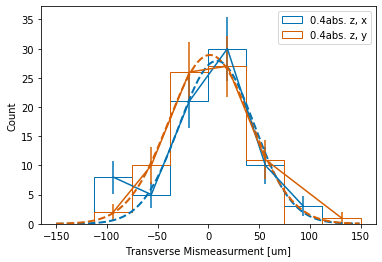

sigma x:  48.54167716062702 +/- 4.990571967612517
sigma y:  38.85195028961139 +/- 3.298989598294914


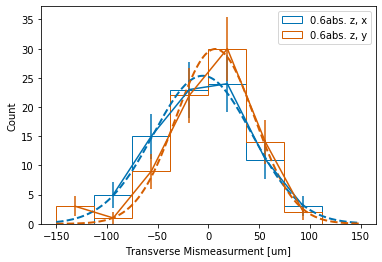

sigma x:  47.39368672675103 +/- 4.934766299253599
sigma y:  43.694964432892704 +/- 4.257495404284914


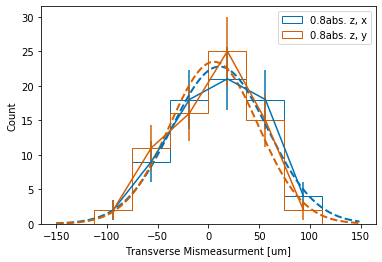

sigma x:  69.35944619396457 +/- 8.914855488938397
sigma y:  62.458580799347665 +/- 7.4849562712174205


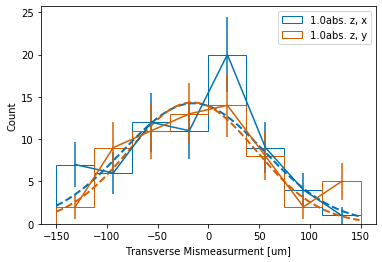

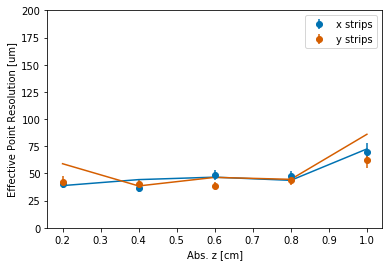

In [4]:
for V in Vmesh:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Location of data
    if V == 540:
        # Vmesh = 540 has multiple files
        file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]
    else:
        file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/"+str(V)+"Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / 9.0 ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / 4.5 ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")

    # plot the x hits
    strip_edges = np.arange(-0.5,512.5,1.0)


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits that are within 25 degrees of vertical
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) & (df_cluster.L <= 28) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, gain_x=9, gain_y=4.5, v_drift=8.0)

            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 41.1, T_H=250)
            dsp.prune_track2(gap=1)

            mu = T_off.iloc[0]["Mu"]
            sigma = T_off.iloc[0]["Sigma"]
            n_sigma = 3
            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c)

                all_z = np.append(all_z,z_vals)
                all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2)


    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    plt.plot(abs_z_std,x_std,color=colors["blue"])
    plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")




# UH NoDLC Micromegas - Quadrant a

In [5]:
Vmesh = [540]

----------- Vmesh =  540 -----------
selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


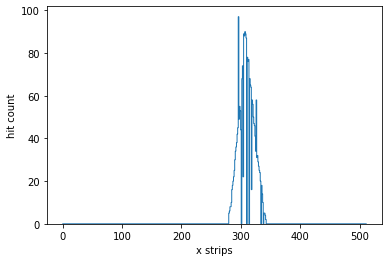

----- Hits on y strips -----


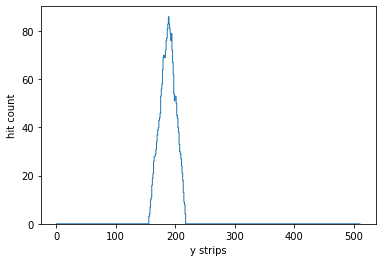

----- Event Time Range-----


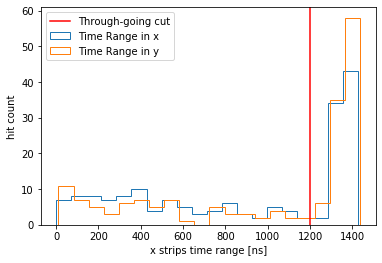

----- ADC distribution-----


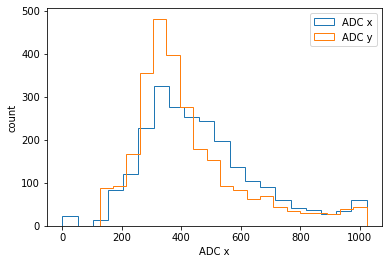

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  17
----- hits in x and y  -----


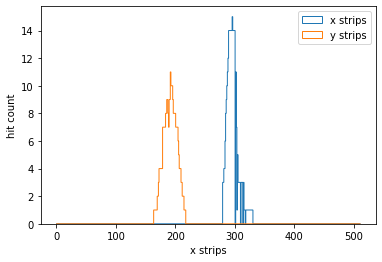

sigma x:  49.396139030674796 +/- 5.696259007938303
sigma y:  52.04636606244084 +/- 7.255181122317869


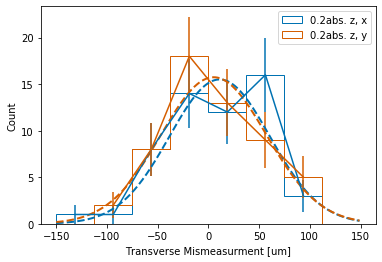

sigma x:  45.40684276128333 +/- 4.547812574343757
sigma y:  47.498905661890205 +/- 4.9025979269732645


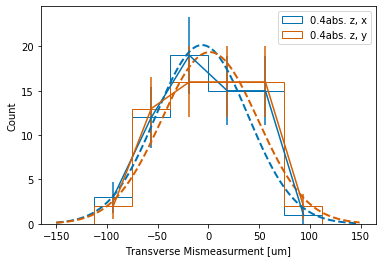

sigma x:  42.18973793532606 +/- 4.346550626874751
sigma y:  46.86978251386229 +/- 5.330847066919735


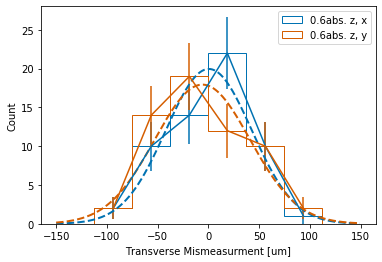

sigma x:  64.38362517775703 +/- 9.72801729277902
sigma y:  49.23420364964084 +/- 5.908762702097712


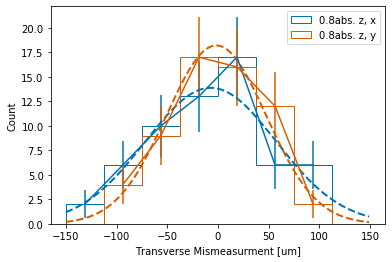

sigma x:  57.91819971543166 +/- 7.792712395889635
sigma y:  62.92368339052602 +/- 9.207986031364214


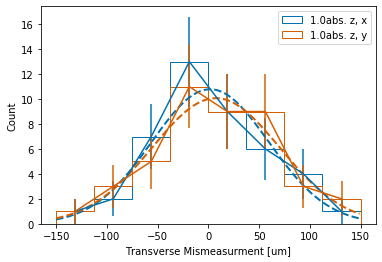

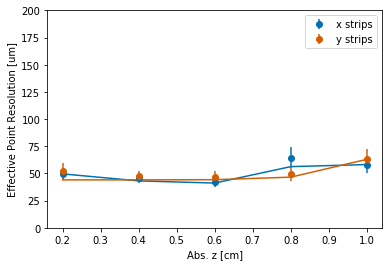

In [6]:
for V in Vmesh:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Location of data
    if V == 540:
        # Vmesh = 540 has multiple files
        file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]
    else:
        file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/"+str(V)+"Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / 9.0 ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / 4.5 ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")

    # plot the x hits
    strip_edges = np.arange(-0.5,512.5,1.0)


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits that are within 25 degrees of vertical
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) & (df_cluster.L <= 28) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, gain_x=9, gain_y=4.5, v_drift=8.0)

            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 41.1, T_H=250)
            dsp.prune_track2(gap=1)

            mu = T_off.iloc[4]["Mu"]
            sigma = T_off.iloc[4]["Sigma"]
            n_sigma = 3
            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c)

                all_z = np.append(all_z,z_vals)
                all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2)


    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    plt.plot(abs_z_std,x_std,color=colors["blue"])
    plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")





# UoS

In [7]:
Vmesh = [850,860,870]
Vmesh = [870]



----------- Vmesh =  870 -----------
----- Hits on x strips -----


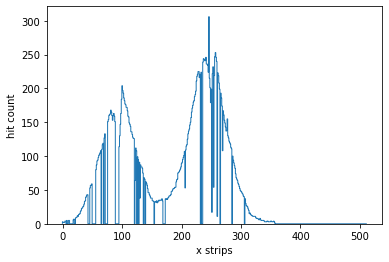

----- Hits on y strips -----


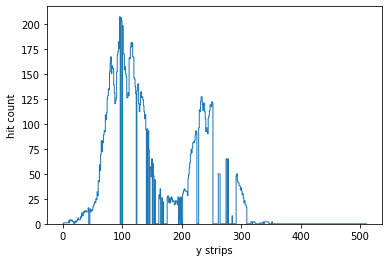

----- Event Time Range-----


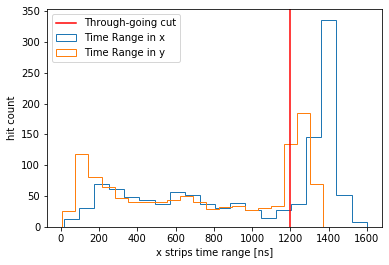

----- ADC distribution-----


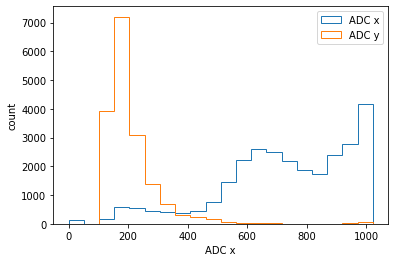

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  9
----- hits in x and y  -----


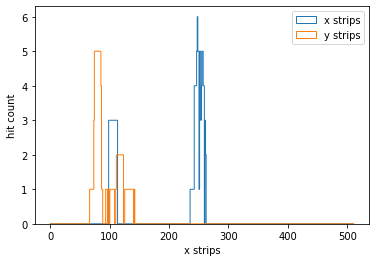

sigma x:  86.92595585580945 +/- 58.56770775158802
sigma y:  31.84778040516408 +/- 8.667885656664499


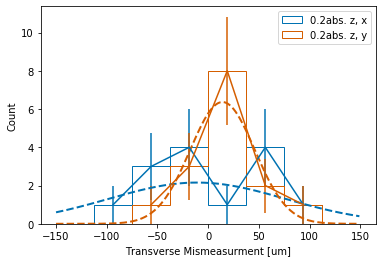

sigma x:  60.03314277177961 +/- 21.117919044741452
sigma y:  133.69209736759046 +/- 251.22904528277402


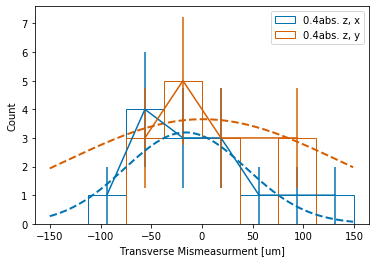

sigma x:  41.197859629835946 +/- 12.54472021050251
sigma y:  21.436374657839064 +/- 4.7422254491463


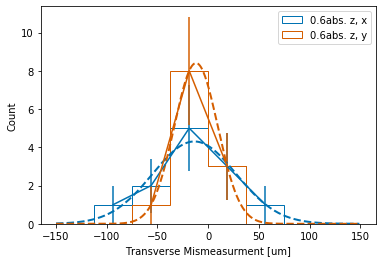

fit failed for z =  0.8
fit failed for z =  1.0


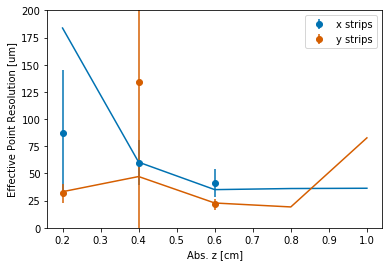

In [8]:
for V in Vmesh:

    print("-----------", "Vmesh = ", str(V), "-----------")


    file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UoS/Po210/"+str(V)+"Vmesh_1_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UoS/Po210/"+str(V)+"Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]


    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)


    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x / 1.0 ) ) # 1 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / 1.0 ) ) # 1 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)


    # plot the x hits
    strip_edges = np.arange(-0.5,512.5,1.0)


    print("----- Hits on x strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits that are within 25 degrees of vertical
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) & (df_cluster.L <= 22.4) ] # This is different from UH due to the wider pitch
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, gain_x=1.0, gain_y=1.0, v_drift=8.0, n_strips_x = 358, n_strips_y=358, pitch_x=250, pitch_y=250)

            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 54.5, T_H=250)
            dsp.prune_track2(gap=1)

            mu = T_off.iloc[8]["Mu"]
            sigma = T_off.iloc[8]["Sigma"]
            n_sigma = 3
            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points
            if len(y) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c)

                all_z = np.append(all_z,z_vals)
                all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2)


    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    plt.plot(abs_z_std,x_std,color=colors["blue"])
    plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")



